#### Analysis of PCA of several animals

In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
from features import ffv
from matlab_util import str_lfp, gp_lfp
from plotting import rasterize

In [4]:
cd ../_data/matlabData

/home/gustav/Documents/DD142X/code/_data/matlabData


In [5]:
files = !ls
print(files)

['NPR-075.b11.mat', 'NPR-075.b13.mat', 'NPR-075.c013.mat', 'NPR-075.c08.mat', 'NPR-075.d07.mat', 'NPR-076.b05.mat', 'NPR-076.b09.mat', 'NPR-076.c09.mat', 'NPR-076.d07.mat']


In [6]:
import numpy as np
import matplotlib.pyplot as plt

ep = 2 ** 11
print("Epoch length: " + str(1000 * ep / 16000) + "ms")

str_epochs = np.concatenate([
    str_lfp(filename, ep).reshape((-1, ep)) for filename in files
], axis = 0)

gp_epochs = np.concatenate([
    gp_lfp(filename, ep).reshape((-1, ep)) for filename in files
], axis = 0)

print(str_epochs.shape)
print(gp_epochs.shape)

Epoch length: 128.0ms
(65872, 2048)
(97678, 2048)


In [9]:
strides = 10
lo = 5
hi = 45
fft_n = 2 ** 14


incr_str = int(str_epochs.shape[0] / strides)
strs = [
    ffv(
        str_epochs[i * incr_str : (i + 1) * incr_str],
        epoch_size = ep,
        lo = lo,
        hi = hi,
        fft_n = fft_n
    ) for i in range(0, strides)
]

incr_gp = int(gp_epochs.shape[0] / strides)
gps = [
    ffv(
        gp_epochs[i * incr_gp : (i + 1) * incr_gp],
        epoch_size = ep,
        lo = lo,
        hi = hi,
        fft_n = fft_n
    ) for i in range(0, strides)
]

In [10]:
frqs = strs[0][1]
print(frqs)

[ 5.859375   6.8359375  7.8125     8.7890625  9.765625  10.7421875
 11.71875   12.6953125 13.671875  14.6484375 15.625     16.6015625
 17.578125  18.5546875 19.53125   20.5078125 21.484375  22.4609375
 23.4375    24.4140625 25.390625  26.3671875 27.34375   28.3203125
 29.296875  30.2734375 31.25      32.2265625 33.203125  34.1796875
 35.15625   36.1328125 37.109375  38.0859375 39.0625    40.0390625
 41.015625  41.9921875 42.96875   43.9453125 44.921875 ]


In [11]:
strs = [str_ for str_, _ in strs]
gps = [ gp_ for gp_, _ in gps]

In [12]:
strs = np.array(strs)
gps = np.array(gps)
features = strs.shape[2]

In [13]:
strs = strs.reshape((-1, features))
gps = gps.reshape((-1, features))
print(strs.shape)
print(gps.shape)

(65870, 41)
(97670, 41)


In [14]:
from sklearn.decomposition import PCA

all_lfp = np.concatenate((strs, gps), axis = 0)
print(all_lfp.shape)

(163540, 41)


In [15]:
pca = PCA(n_components = 10).fit(all_lfp.copy())

In [16]:
pca_all = pca.transform(all_lfp.copy())
pca_str = pca.transform(strs.copy())
pca_gp  = pca.transform(gps.copy())

print(pca_all.shape)
print(pca_str.shape)
print(pca_gp.shape)

(163540, 10)
(65870, 10)
(97670, 10)


PCA n = 163540


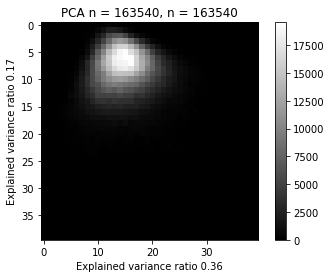

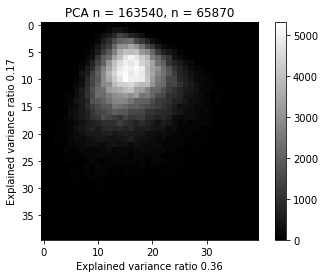

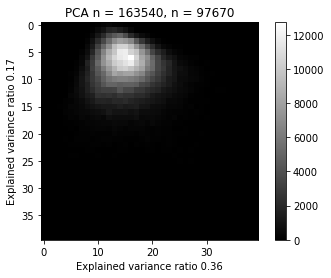

In [17]:
print("PCA n = " + str(pca_all.shape[0]))
x1var, x2var = pca.explained_variance_ratio_[0:2]
x1var = round(x1var, 2)
x2var = round(x2var, 2)

raster_all = rasterize(pca_all)
plt.imshow(raster_all, cmap = 'gray', vmin = np.min(raster_all), vmax = np.max(raster_all))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_all.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

raster_str = rasterize(pca_str)
plt.imshow(raster_str, cmap = 'gray', vmin = np.min(raster_str), vmax = np.max(raster_str))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_str.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

raster_gp = rasterize(pca_gp)
plt.imshow(raster_gp, cmap = 'gray', vmin = np.min(raster_gp), vmax = np.max(raster_gp))
plt.title("PCA n = " + str(pca_all.shape[0]) + ", n = " + str(pca_gp.shape[0]))
plt.xlabel("Explained variance ratio " + str(x1var))
plt.ylabel("Explained variance ratio " + str(x2var))
plt.colorbar()
plt.show()

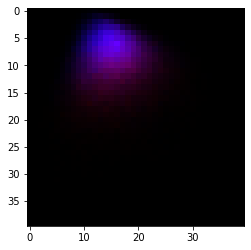

In [66]:
raster__ = np.zeros((40, 40, 3))
raster__[ : , : , 0] = raster_str
raster__[ : , : , 2] = raster_gp
plt.imshow(raster__ / np.max(raster__))
plt.show()

In [67]:
ls

NPR-075.b11.mat   NPR-075.c08.mat  NPR-076.b09.mat
NPR-075.b13.mat   NPR-075.d07.mat  NPR-076.c09.mat
NPR-075.c013.mat  NPR-076.b05.mat  NPR-076.d07.mat


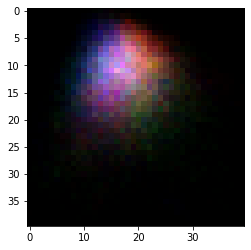

In [73]:
patient_raster = np.zeros((40, 40, 3))
for idx, filename in enumerate(["NPR-075.b11.mat", "NPR-076.b05.mat", "NPR-076.d07.mat"]):
    patient_raster[ : , : , idx] = rasterize(
        pca.transform(
            ffv(
                np.concatenate((
                    str_lfp(filename, epoch_size = ep), 
                    gp_lfp(filename, epoch_size = ep)), 
                    axis = 0
                ),
                lo = lo,
                hi = hi,
                epoch_size = ep,
                fft_n = fft_n
            )[0]
        )
    )
    
plt.imshow(patient_raster / np.max(patient_raster))
plt.show()

In [18]:
print(pca.explained_variance_ratio_.sum())
for ratio, component in zip(pca.explained_variance_ratio_, pca.components_):
    print("Explained variance ratio: " + str(ratio))
    print(component)

0.9705266427210821
Explained variance ratio: 0.35752110741824195
[0.52506115 0.44322685 0.35981754 0.30062249 0.2487563  0.2011328
 0.16951687 0.15585106 0.14709386 0.13477901 0.1215906  0.11515374
 0.10981597 0.10232317 0.09491474 0.08842134 0.08058345 0.06998173
 0.05971059 0.0542974  0.05160194 0.04908829 0.04661747 0.04529053
 0.04401048 0.04179898 0.03941671 0.03898786 0.03814082 0.03584799
 0.03347085 0.03228957 0.03115544 0.02916439 0.02737767 0.02755473
 0.02794581 0.02716606 0.0256673  0.0241388  0.02242054]
Explained variance ratio: 0.17218125449713062
[-0.26377295 -0.30579679 -0.258196   -0.11760528  0.03434173  0.15553939
  0.22431874  0.23427967  0.21057208  0.18753228  0.18842057  0.21864212
  0.25789769  0.28635766  0.29260598  0.27424148  0.23644123  0.1877224
  0.13994619  0.10566173  0.08564167  0.07404328  0.0644763   0.05455878
  0.04264762  0.02953739  0.0202432   0.02077087  0.02765598  0.03492546
  0.03811353  0.03500381  0.02682858  0.01699365  0.01064297  0.011

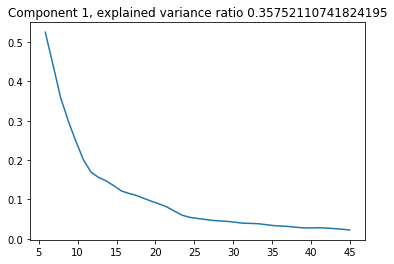

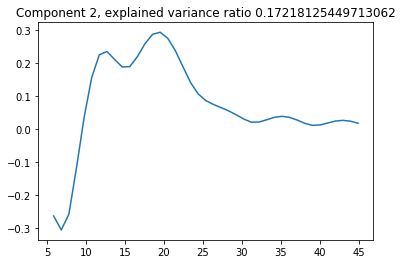

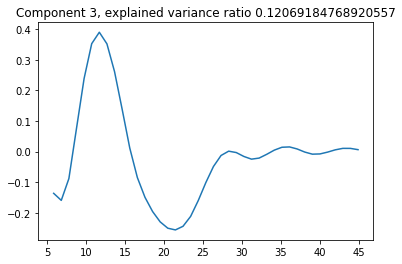

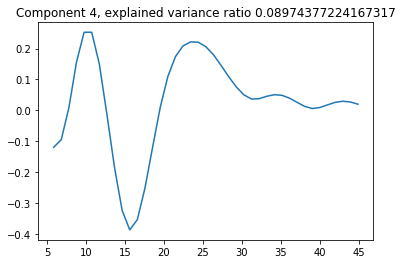

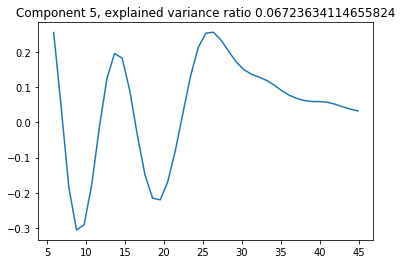

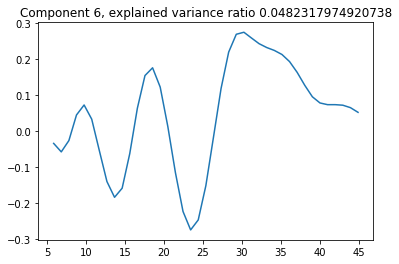

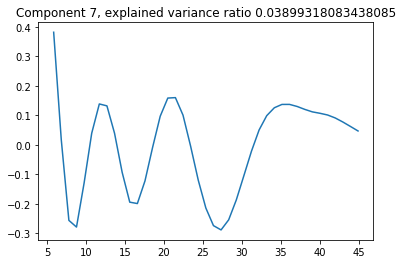

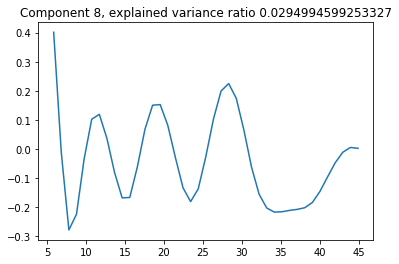

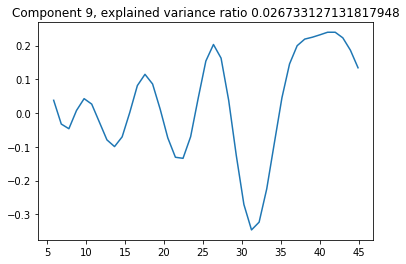

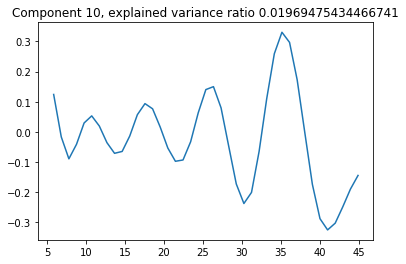

In [19]:
for idx, (ratio, component) in enumerate(zip(pca.explained_variance_ratio_, pca.components_)):
    plt.clf()
    plt.title("Component " + str(idx + 1) + ", explained variance ratio " + str(ratio))
    plt.plot(frqs, component)
    plt.show()

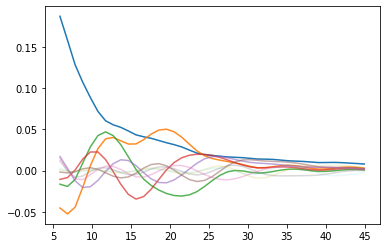

In [20]:
plt.clf()
for idx, (ratio, component) in enumerate(zip(pca.explained_variance_ratio_, pca.components_)):
    plt.plot(frqs, ratio * component, alpha = 1 - idx/10)
plt.show()

In [23]:
pca.explained_variance_ratio_[0:6].sum()

0.8556061204848835

In [24]:
mmls

NPR-075.b11.mat   NPR-075.c08.mat  NPR-076.b09.mat
NPR-075.b13.mat   NPR-075.d07.mat  NPR-076.c09.mat
NPR-075.c013.mat  NPR-076.b05.mat  NPR-076.d07.mat


In [26]:
animal1_str = str_lfp("NPR-075.b11.mat", epoch_size = ep)
animal1_gp = gp_lfp("NPR-075.b11.mat", epoch_size = ep)
animal2_str = str_lfp("NPR-076.d07.mat", epoch_size = ep)
animal2_gp = gp_lfp("NPR-076.d07.mat", epoch_size = ep)

In [29]:
print(animal1_str.shape)
print(animal1_gp.shape)
print(animal2_str.shape)
print(animal2_gp.shape)

(11, 1587200)
(15, 1587200)
(11, 1597440)
(13, 1597440)


In [37]:
animal1 = np.concatenate((animal1_str.reshape((-1, ep)), animal1_gp.reshape((-1, ep))), axis = 0)
animal2 = np.concatenate((animal2_str.reshape((-1, ep)), animal2_gp.reshape((-1, ep))), axis = 0)
strs_ = np.concatenate((animal1_str.reshape((-1, ep)), animal2_str.reshape((-1, ep))), axis = 0)
gps_ = np.concatenate((animal1_gp.reshape((-1, ep)), animal2_gp.reshape((-1, ep))), axis = 0)

In [38]:
print(animal1.shape)
print(animal2.shape)
print(strs_.shape)
print(gps_.shape)

(20150, 2048)
(18720, 2048)
(17105, 2048)
(21765, 2048)


In [39]:
animal1, frqs2 = ffv(animal1, epoch_size = ep, lo = lo, hi = hi, fft_n = fft_n)
animal2, _ = ffv(animal2, epoch_size = ep, lo = lo, hi = hi, fft_n = fft_n)
strs_, _ = ffv(strs_, epoch_size = ep, lo = lo, hi = hi, fft_n = fft_n)
gps_, _ = ffv(gps_, epoch_size = ep, lo = lo, hi = hi, fft_n = fft_n)

print(frqs2)
print(animal1.shape)
print(animal2.shape)
print(strs_.shape)
print(gps_.shape)

[ 5.859375   6.8359375  7.8125     8.7890625  9.765625  10.7421875
 11.71875   12.6953125 13.671875  14.6484375 15.625     16.6015625
 17.578125  18.5546875 19.53125   20.5078125 21.484375  22.4609375
 23.4375    24.4140625 25.390625  26.3671875 27.34375   28.3203125
 29.296875  30.2734375 31.25      32.2265625 33.203125  34.1796875
 35.15625   36.1328125 37.109375  38.0859375 39.0625    40.0390625
 41.015625  41.9921875 42.96875   43.9453125 44.921875 ]
(20150, 41)
(18720, 41)
(17105, 41)
(21765, 41)


In [40]:
animal1_pca = pca.transform(animal1.copy())
animal2_pca = pca.transform(animal2.copy())
strs_pca = pca.transform(strs_.copy())
gps_pca = pca.transform(gps_.copy())

print(animal1_pca.shape)
print(animal2_pca.shape)
print(strs_pca.shape)
print(gps_pca.shape)

(20150, 10)
(18720, 10)
(17105, 10)
(21765, 10)


In [45]:
print(animal1_pca.mean(axis = 0)[:6])
print(animal2_pca.mean(axis = 0)[:6])
print(strs_pca.mean(axis = 0)[:6])
print(gps_pca.mean(axis = 0)[:6])
print(pca.explained_variance_ratio_[:6].sum())

[-0.63584792 -4.01466933  0.92040126 -0.5802833  -2.89432668 -2.80728904]
[ 4.6755453   2.49453677  1.47733193 -2.15309996  1.83409426  3.92311068]
[ 3.51078744 -4.44867389  2.77428971 -1.29476778 -0.06457459  1.34915228]
[ 0.67364361  1.92495788 -0.05754589 -1.37154776 -1.05131586 -0.28502146]
0.8556061204848835


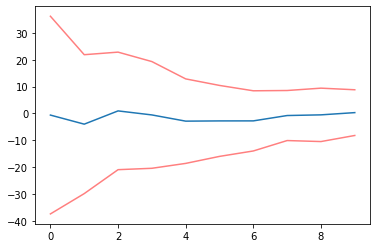

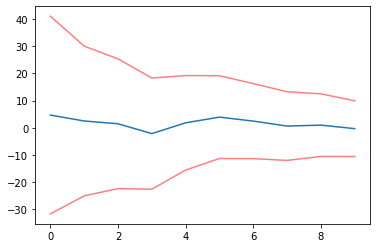

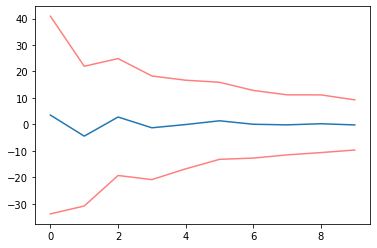

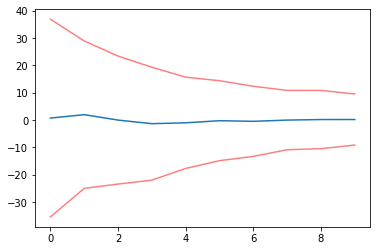

In [46]:
for pcs in [animal1_pca, animal2_pca, strs_pca, gps_pca]:
    plt.clf()
    plt.plot(pcs.mean(axis = 0))
    plt.plot(pcs.mean(axis = 0) + pcs.std(axis = 0), 'r', alpha = 0.5)
    plt.plot(pcs.mean(axis = 0) - pcs.std(axis = 0), 'r', alpha = 0.5)
    plt.show()

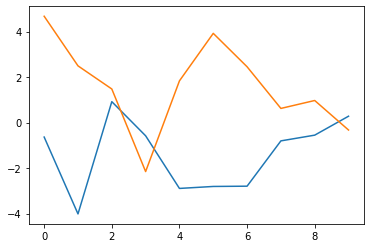

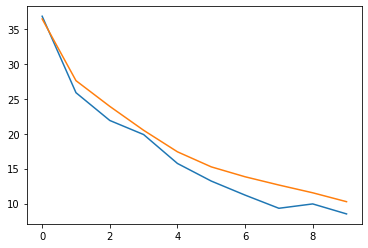

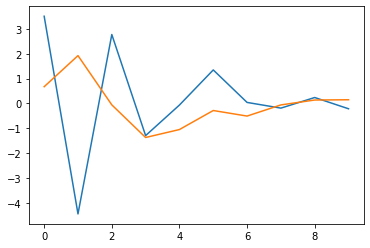

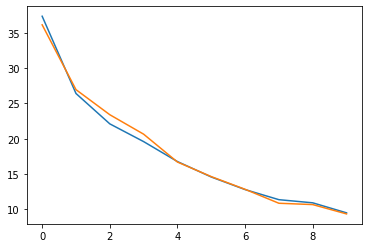

In [48]:
for pcs in [animal1_pca, animal2_pca]:
    plt.plot(pcs.mean(axis = 0))
plt.show()
for pcs in [animal1_pca, animal2_pca]:
    plt.plot(pcs.std(axis = 0))
plt.show()

for pcs in [strs_pca, gps_pca]:
    plt.plot(pcs.mean(axis = 0))
plt.show()
for pcs in [strs_pca, gps_pca]:
    plt.plot(pcs.std(axis = 0))
plt.show()

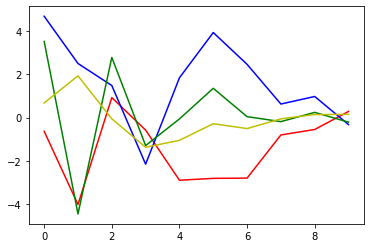

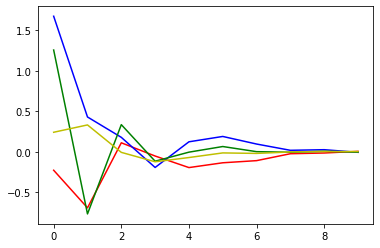

In [56]:
for pcs, col in zip(
    [animal1_pca, animal2_pca, strs_pca, gps_pca],
    ['r', 'b', 'g', 'y']
):
    plt.plot(pcs.mean(axis = 0), col)
plt.show()
    
for pcs, col in zip(
    [animal1_pca, animal2_pca, strs_pca, gps_pca],
    ['r', 'b', 'g', 'y']
):
    plt.plot(pcs.mean(axis = 0) * pca.explained_variance_ratio_, col)
plt.show()

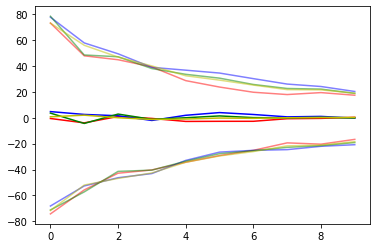

In [74]:
for pcs, col in zip(
    [animal1_pca, animal2_pca, strs_pca, gps_pca],
    ['r', 'b', 'g', 'y']
):
    plt.plot(pcs.mean(axis = 0), col)
    plt.plot(pcs.mean(axis = 0) + 2 * pcs.std(axis = 0), col, alpha = 0.5)
    plt.plot(pcs.mean(axis = 0) - 2 * pcs.std(axis = 0), col, alpha = 0.5)
plt.show()